In [1]:
# paths
new_path_dataset ='/home/marrakchi/TFM/TFM_env/Datasets/EmoFilm/'
path_dataset ='/home/marrakchi/TFM/TFM_env/Datasets/ExKaldiASRDatasetFormat/' 
#ROOT_FOLDERS ='/home/marrakchi/TFM/TFM_env/Datasets/inter1sp/'

In [8]:
# Systems Libraries
import os
from os import listdir
from shutil import copyfile

# For data processing
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from IPython.display import display, HTML # For displaying tables
import string # for text processing
import IPython as ipd
import librosa
import librosa.display
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

# Import exkaldi package
import exkaldi
exkaldi.info.reset_kaldi_root('/kaldi')
from exkaldi import declare

# ExKaldi Configuration
ExKaldiInfo = exkaldi.info
print(ExKaldiInfo)
print(ExKaldiInfo.KALDI)
print(ExKaldiInfo.KALDI_ROOT)

ExKaldiInfo(version='1.3.5.4', major='1', minor='3', patch='5', upload='4')
Kaldi(version='5.5', major='5', minor='5')
/kaldi


# Data processing

In [3]:
spanish_list = []
audios_list = listdir(new_path_dataset+'wav_corpus/')
for i,audio in enumerate(audios_list):
    if i==0:
        print(audio)
    if audio[-6:-4] == 'es':
        spanish_list.append(audio)
        #copyfile(new_path_dataset+'wav_corpus/'+audio, new_path_dataset+'wav/'+audio)

m_gio001ait.wav


In [4]:
# Sort the files by name
spanish_list.sort()

In [5]:
print(spanish_list)

['f_ans001aes.wav', 'f_ans002aes.wav', 'f_ans003aes.wav', 'f_ans004aes.wav', 'f_ans007aes.wav', 'f_ans009aes.wav', 'f_ans009bes.wav', 'f_ans010aes.wav', 'f_ans010bes.wav', 'f_ans012aes.wav', 'f_ans018aes.wav', 'f_ans019aes.wav', 'f_ans024aes.wav', 'f_ans030aes.wav', 'f_ans040aes.wav', 'f_ans041aes.wav', 'f_ans041bes.wav', 'f_ans042aes.wav', 'f_ans042bes.wav', 'f_ans043aes.wav', 'f_ans044aes.wav', 'f_ans044bes.wav', 'f_ans045aes.wav', 'f_ans049aes.wav', 'f_ans050aes.wav', 'f_ans901aes.wav', 'f_ans901bes.wav', 'f_ans901ces.wav', 'f_ans902aes.wav', 'f_ans902bes.wav', 'f_ans902ces.wav', 'f_ans902des.wav', 'f_ans905aes.wav', 'f_dis008aes.wav', 'f_dis009aes.wav', 'f_dis014aes.wav', 'f_dis014bes.wav', 'f_dis016aes.wav', 'f_dis017aes.wav', 'f_dis019aes.wav', 'f_dis019bes.wav', 'f_dis019ces.wav', 'f_dis020aes.wav', 'f_dis024aes.wav', 'f_dis024bes.wav', 'f_dis025aes.wav', 'f_dis027aes.wav', 'f_dis027bes.wav', 'f_dis028aes.wav', 'f_dis029aes.wav', 'f_dis036aes.wav', 'f_dis036bes.wav', 'f_dis037ae

In [67]:
# Preparing data structure for ExKaldi (WAV file, text file)

# Prepare ExKaldi files
#transcription = exkaldi.Transcription(name="trans")
utt2spk = exkaldi.ListTable(name="utt2spk")
spk2utt = exkaldi.ListTable(name="spk2utt")
wavScp = exkaldi.ListTable(name="wavScp")

# Read dataset transcriptions
X = pd.read_excel(new_path_dataset+'f_m_corpus_it_es_en_legend.xlsx', sheet_name='female',header=0, usecols=[0,1])
X2 = pd.read_excel(new_path_dataset+'f_m_corpus_it_es_en_legend.xlsx', sheet_name='male',header=0, usecols=[0,1])

# Mix both datasets into one
data = pd.concat([X, X2], ignore_index=True)

# Remove all rows with non-spanish audios
df = data[data.file.str.contains("es", na=False)]
df = df.reset_index(drop=True) # Refrech indexes

# # Convert to plain text. Remove accents and any other symbols like ¨, æ, etc. 
df['speaker'] = df['speaker'].str.normalize('NFKD').str.encode('ascii', errors='ignore').str.decode('utf-8')
#Display
display(HTML(df[-10:].to_html()))


,file,speaker
349,m_tri020aes,Juan Carlos Gustmens
350,m_tri020bes,Juan Carlos Gustmens
351,m_tri021aes,Juan Carlos Gustmens
352,m_tri021bes,Juan Carlos Gustmens
353,m_tri025aes,Ramon Langa
354,m_tri028aes,Ramon Langa
355,m_tri029aes,Ramon Langa
356,m_tri030bes,Ramon Langa
357,m_tri030ces,Ramon Langa
358,m_tri039aes,Sergio Zamora


In [68]:
for num,row in enumerate (df.file):
    uttID = row.lower()
    #print(uttID)
    #print(df.speaker[num])
    speaker = df.speaker[num].split()[0]
    #if num == 0:
    #    print(uttID)
    #    print(speaker)
    # 1. text
    #transcription[uttID] = df.LBO[num]
    # 4. wav.scp
    wavFilePath = os.path.join(new_path_dataset,'wav/',uttID +'.wav')
    wavScp[uttID] = wavFilePath
    # 2. utt2spk
    utt2spk[uttID] = speaker
    # 3. spk2utt
    if speaker not in spk2utt.keys():
        spk2utt[speaker] = f"{uttID}"
    else:
        spk2utt[speaker] += f" {uttID}"

# Save files
#transcription.sort().save( os.path.join(new_path_dataset, "text") )
utt2spk.save( os.path.join(new_path_dataset, "utt2spk") )
spk2utt.save( os.path.join(new_path_dataset, "spk2utt") )  
wavScp.sort().save(os.path.join(new_path_dataset,"wav.scp") )

'/home/marrakchi/TFM/TFM_env/Datasets/EmoFilm/wav.scp'

# Sample

In [6]:
def plot_mfccs(m):
    plt.figure(figsize=(10,5))
    librosa.display.specshow(m, x_axis='time')
    plt.colorbar()
    plt.title("13 MFCCs")
    plt.tight_layout()
    plt.show()

    
def plot_spec(sp, title=''):
    plt.figure(figsize=(10,5))
    sp_DB = librosa.power_to_db(sp, ref=np.max)
    librosa.display.specshow(sp_DB, x_axis='time', y_axis='mel', fmax=8000)
    plt.colorbar(format='%+2.0f dB')
    plt.title("Spectrograms of " + title)
    #plt.canvas.draw()
    #plt.tight_layout()
    plt.show()
    
def plot_raw_audio(audio_data, sr, title=''):
    """
    INPUTS:
    - audio_data: tensor of the raw audio.
    - sr: Sample Rate
    - label: Utterance of the audio.
    """
    plt.figure(figsize=(10,5))
    librosa.display.waveplot(audio_data, sr=sr)
    title = "Raw signal of the file " + title
    plt.title(title)
    plt.xlabel('Time')
    plt.ylabel('Amplitude')
    plt.show()


def plot_all(audio_data, spec, mfcc, sr, file, mfccs=None):
    plot_raw_audio(audio_data, sr, file)
    plot_spec(spec, file)
    plot_mfccs(mfcc)

In [5]:
ipd.display.Audio(filename=new_path_dataset+'wav/f_ans001aes.wav')

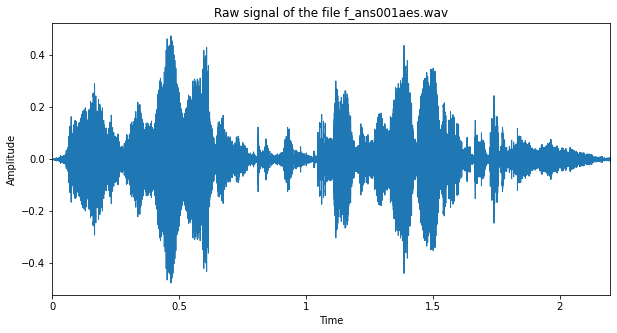

/home/marrakchi/TFM/TFM_env/lib/python3.6/site-packages/librosa/display.py:974: MatplotlibDeprecationWarning: The 'basey' parameter of __init__() has been renamed 'base' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  scaler(mode, **kwargs)
/home/marrakchi/TFM/TFM_env/lib/python3.6/site-packages/librosa/display.py:974: MatplotlibDeprecationWarning: The 'linthreshy' parameter of __init__() has been renamed 'linthresh' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  scaler(mode, **kwargs)


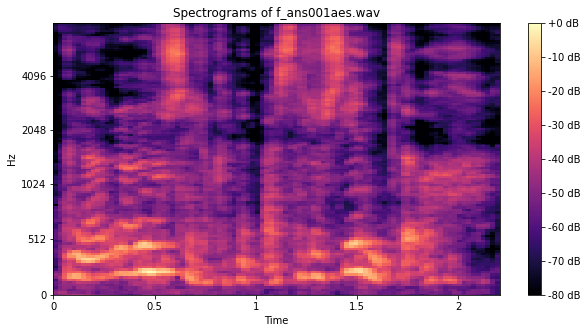

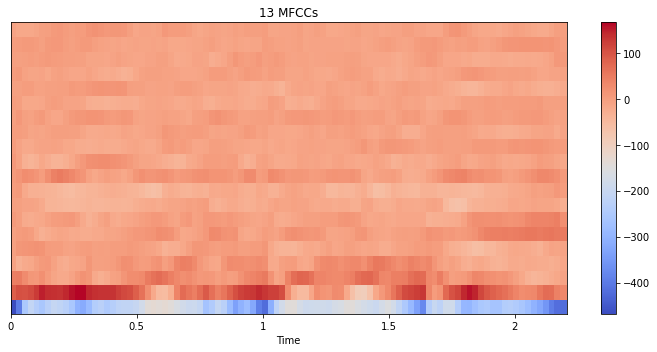

In [9]:
(waveform, sample_rate) = librosa.load(new_path_dataset+'wav/f_ans001aes.wav')
spectrogram = librosa.feature.melspectrogram(y=waveform, sr=sample_rate)
mfcc = librosa.feature.mfcc(y=waveform, sr=sample_rate)
plot_all(audio_data=waveform, spec=spectrogram, mfcc=mfcc, sr=sample_rate, file='f_ans001aes.wav')

# Compute MFCCs

In [6]:
# Parameters
parallel = 1
mfccConfig={"--use-energy":"true"}
print(ExKaldiInfo.timeout)
ExKaldiInfo.set_timeout(28800) # 1/2 hour
print(ExKaldiInfo.timeout)

500
28800


In [7]:
feat = exkaldi.compute_mfcc(
                        os.path.join(new_path_dataset,"wav.scp"),
                        config=mfccConfig
                        #outFile=os.path.join(path_dataset,"mfcc","train","raw_mfcc.ark")
                    )
feat.save( os.path.join(new_path_dataset,"mfcc","raw_mfcc.ark") )
print(f"Generate SER_Dataset raw MFCC feature done.")

Generate SER_Dataset raw MFCC feature done.


In [8]:
# Compute CMVN
print('Start CMVN')
cmvn = exkaldi.compute_cmvn_stats(
                                feat=feat,
                                spk2utt=os.path.join(new_path_dataset,"spk2utt"),
                            )
cmvn.save( os.path.join(new_path_dataset,"mfcc","cmvn.ark") )
print(f"Generate CMVN statistics done.")
# Apply CMVN
feat = exkaldi.use_cmvn(
                    feat=feat,
                    cmvn=cmvn,
                    utt2spk=os.path.join(new_path_dataset,"utt2spk"),
                )
feat.save(os.path.join(new_path_dataset,"mfcc","mfcc_cmvn.ark"))
print(f"Generate MFCC feature (applied CMVN) done.")

Start CMVN
Generate CMVN statistics done.
Generate MFCC feature (applied CMVN) done.


In [13]:
feat.utts

['f_ans001aes',
 'f_ans002aes',
 'f_ans003aes',
 'f_ans004aes',
 'f_ans007aes',
 'f_ans009aes',
 'f_ans009bes',
 'f_ans010aes',
 'f_ans010bes',
 'f_ans012aes',
 'f_ans018aes',
 'f_ans019aes',
 'f_ans024aes',
 'f_ans030aes',
 'f_ans040aes',
 'f_ans041aes',
 'f_ans041bes',
 'f_ans042aes',
 'f_ans042bes',
 'f_ans043aes',
 'f_ans044aes',
 'f_ans044bes',
 'f_ans045aes',
 'f_ans049aes',
 'f_ans050aes',
 'f_ans901aes',
 'f_ans901bes',
 'f_ans901ces',
 'f_ans902aes',
 'f_ans902bes',
 'f_ans902ces',
 'f_ans902des',
 'f_ans905aes',
 'f_dis008aes',
 'f_dis009aes',
 'f_dis014aes',
 'f_dis014bes',
 'f_dis016aes',
 'f_dis017aes',
 'f_dis019aes',
 'f_dis019bes',
 'f_dis019ces',
 'f_dis020aes',
 'f_dis024aes',
 'f_dis024bes',
 'f_dis025aes',
 'f_dis027aes',
 'f_dis027bes',
 'f_dis028aes',
 'f_dis029aes',
 'f_dis036aes',
 'f_dis036bes',
 'f_dis037aes',
 'f_dis038aes',
 'f_dis042aes',
 'f_dis043aes',
 'f_dis049aes',
 'f_dis108aes',
 'f_dis150aes',
 'f_dis201aes',
 'f_dis202aes',
 'f_dis204aes',
 'f_dis2

# Get predicted transcriptions

In [3]:
# ARGS
delta = 2 #(n-order to add to the feature)
numIters = 35 # Training iterations
maxIterInc = 25 # Final iteration of increasing gaussians
realignIter = [10,20,30] # iteration to allign feature
order = 5 # N-GRAM to use (min 1 | max 6)
beam = 13 # Decode beam size
latBeam = 6 # Lattice beam size
acwt = 0.083333 # Acoustic model weight
parallel = 1 # parallel process to compute feature of train dataset (min 1 | max 10)
skipTrain = False # If True, skip training. Do decoding only
splice = 3 # How many left-right frames to splice
fmllrIter = [2,4,6,12] # The iteration to estimate fmllr matrix

In [4]:
declare.is_file( os.path.join(path_dataset,"train_sat","final.mdl") )
declare.is_file( os.path.join(path_dataset,"train_sat","tree") )

# Load tree
tree = exkaldi.load_tree( os.path.join(path_dataset,"train_sat","tree") )
# Load model
hmm = exkaldi.load_hmm( os.path.join(path_dataset,"train_sat","final.mdl") )
HCLGfile=os.path.join(path_dataset,"train_sat","graph",f"HCLG.{order}.fst")
tansformMatFile=os.path.join(path_dataset,"train_lda_mllt","trans.mat")
outDir=os.path.join(new_path_dataset,"train_sat",f"decode_{order}grams") # --> New Dataset path

# Load dictionary/lexicon
lexicons = exkaldi.load_lex(os.path.join(path_dataset,"dict","lexicons.lex"))

In [5]:
#print(f"Load test feature.")
feat = exkaldi.load_feat(os.path.join(new_path_dataset,"mfcc","mfcc_cmvn.ark"))

print(f"Transform features")
if tansformMatFile is None:
    print("Feature type is delta. Add 2-order deltas.")
    feat = feat.add_delta(order=delta)
    feat = feat.save(os.path.join(outDir,"mfcc_cmvn_delta.ark"),returnIndexTable=True)
else:
    print("Feature type is lda+mllt")
    feat = feat.splice(left=splice,right=splice)
    print("Transform feature")
    feat = exkaldi.transform_feat(feat, tansformMatFile)
    feat = feat.save(os.path.join(outDir,"mfcc_cmvn_lda.ark"),returnIndexTable=True)

## 1. Estimate the primary transform matrix from alignment or lattice.
## We estimate it from lattice, so we decode it firstly.
print("Decode the first time with original feature.")
preLat = exkaldi.decode.wfst.gmm_decode(
                                    feat, 
                                    hmm, 
                                    HCLGfile, 
                                    symbolTable=lexicons("words"),
                                    beam=10, 
                                    latBeam=6, 
                                    acwt=acwt,
                                    maxActive=2000,
                                )
preLat.save(os.path.join(outDir,"test_premary.lat"))
preLat

print("Estimate the primary fMLLR transform matrix.")
preTransMatrix = exkaldi.hmm.estimate_fMLLR_matrix(
                                    aliOrLat=preLat,
                                    lexicons=lexicons,
                                    aliHmm=hmm, 
                                    feat=feat,
                                    adaHmm=None,
                                    silenceWeight=0.01,
                                    acwt=acwt,
                                    spk2utt=os.path.join(new_path_dataset,"spk2utt"),
                                )
del preLat
## 2. Transform feature. We will use new feature to estimate the secondary transform matrix from lattice.
print("Transform feature with primary matrix.")
fmllrFeat = exkaldi.use_fmllr(
                    feat,
                    preTransMatrix,
                    utt2spk=os.path.join(new_path_dataset,"utt2spk"),
                )
print("Decode the second time with primary fmllr feature.")
secLat = exkaldi.decode.wfst.gmm_decode(
                                    fmllrFeat, 
                                    hmm, 
                                    HCLGfile, 
                                    symbolTable=lexicons("words"),
                                    beam=beam,
                                    latBeam=latBeam,
                                    acwt=acwt,
                                    maxActive=7000,
                                    config={"--determinize-lattice":"false"},
                                )
print("Determinize secondary lattice.")
thiLat = secLat.determinize(acwt=acwt, beam=4)
print("Estimate the secondary fMLLR transform matrix.")
secTransMatrix = exkaldi.hmm.estimate_fMLLR_matrix(
                                    aliOrLat=thiLat,
                                    lexicons=lexicons,
                                    aliHmm=hmm, 
                                    feat=fmllrFeat,
                                    adaHmm=None,
                                    silenceWeight=0.01,
                                    acwt=acwt,
                                    spk2utt=os.path.join(new_path_dataset,"spk2utt"),
                                )
del fmllrFeat
del thiLat
## 3. Compose the primary matrix and secondary matrix and get the final transform matrix.
print("Compose the primary and secondary transform matrix.")
finalTransMatrix = exkaldi.hmm.compose_transform_matrixs(
                                                    matA=preTransMatrix,
                                                    matB=secTransMatrix,
                                                    bIsAffine=True,
                                                )
finalTransMatrix.save(os.path.join(outDir,"trans.ark"))
print("Transform feature with final matrix.")
## 4. Transform feature with the final transform matrix and use it to decode.
## We directly use the lattice generated in the second step. The final lattice is obtained.
finalFmllrFeat = exkaldi.use_fmllr(
                                feat,
                                finalTransMatrix,
                                utt2spk=os.path.join(new_path_dataset,"utt2spk"),
                            )
del finalTransMatrix
print("Rescore secondary lattice.")
lat = secLat.am_rescore(
                    hmm=hmm,
                    feat=finalFmllrFeat,
                )
print("Determinize secondary lattice.")
lat = lat.determinize(acwt=acwt, beam=6)
lat.save(os.path.join(outDir,"test.lat"))
#lat = exkaldi.load_lat(os.path.join(outDir,"test.lat"))
print("Generate lattice done.")

# GET THE PREDICTED TRANSCRIPTIONS
penalty = 1
LMWT = 10
# Add penalty
newLat = lat.add_penalty(penalty)
# RESULTADOS PREDECIDOS (int)
# Get 1-best result (phone-level)
result = newLat.get_1best(lexicons("words"), hmm, lmwt=LMWT, acwt=1, phoneLevel=False)
print(result.subset(nHead=1))
# RESULTADOS PREDECIDOS (palabras)
# Transform from int value format to text format
result = exkaldi.hmm.transcription_from_int(result, lexicons("words"))
print(result.subset(nHead=1))

print("Save predicted transcriptions.")
result.save(os.path.join(outDir, "hyp_words.txt") )
#with open(os.path.join(outDir,"best_WER"),"w") as fw:
#    fw.write( f"WER {bestWER[0]}, penalty {bestWER[1]}, LMWT {bestWER[2]}" )

Transform features
Feature type is lda+mllt
Transform feature
Decode the first time with original feature.


KeyboardInterrupt: 

In [5]:
lat = exkaldi.load_lat(os.path.join(outDir,"test.lat"))
print("Generate lattice done.")

# GET THE PREDICTED TRANSCRIPTIONS
penalty = 1
LMWT = 10
# Add penalty
newLat = lat.add_penalty(penalty)
# RESULTADOS PREDECIDOS (int)
# Get 1-best result (phone-level)
result = newLat.get_1best(lexicons("words"), hmm, lmwt=LMWT, acwt=1, phoneLevel=False)
print(result.subset(nHead=1))
# RESULTADOS PREDECIDOS (palabras)
# Transform from int value format to text format
result = exkaldi.hmm.transcription_from_int(result, lexicons("words"))
print(result.subset(nHead=1))

print("Save predicted transcriptions.")
result.save(os.path.join(outDir, "hyp_words.txt") )
#with open(os.path.join(outDir,"best_WER"),"w") as fw:
#    fw.write( f"WER {bestWER[0]}, penalty {bestWER[1]}, LMWT {bestWER[2]}" )

Generate lattice done.
-
{'f_ans001aes': '60234 60234 78858 46185'}
{'f_ans001aes': 'no no se impacienta'}
Save predicted transcriptions.


'/home/marrakchi/TFM/TFM_env/Datasets/EmoFilm/train_sat/decode_5grams/hyp_words.txt'

In [7]:
print(len(result))

340
